In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import necessary libraries.

In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from PIL import Image
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

Unzip the dataset stored in your Google Drive.

In [ ]:
!unzip /content/drive/MyDrive/Projects/archive.zip -d /content/archive

Streaming output truncated to the last 5000 lines.
  inflating: /content/archive/train/0/9684605R.png  
  inflating: /content/archive/train/0/9685238L.png  
  inflating: /content/archive/train/0/9685238R.png  
  inflating: /content/archive/train/0/9686617L.png  
  inflating: /content/archive/train/0/9686617R.png  
  inflating: /content/archive/train/0/9686777R.png  
  inflating: /content/archive/train/0/9686834L.png  
  inflating: /content/archive/train/0/9686834R.png  
  inflating: /content/archive/train/0/9686908L.png  
  inflating: /content/archive/train/0/9686908R.png  
  inflating: /content/archive/train/0/9687273L.png  
  inflating: /content/archive/train/0/9689906R.png  
  inflating: /content/archive/train/0/9690910L.png  
  inflating: /content/archive/train/0/9690910R.png  
  inflating: /content/archive/train/0/9691359L.png  
  inflating: /content/archive/train/0/9691359R.png  
  inflating: /content/archive/train/0/9692163L.png  
  inflating: /content/archive/train/0/9692604L.p

Define paths for training, testing, and validation datasets.

list_of_classes contains the class labels for the dataset.

In [ ]:
train_path = '/content/archive/train'
test_path = '/content/archive/test'
valid_path = '/content/archive/val'
list_of_classes=['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

We have three datasets for training,testing and validation. Finding length of each dataset.Organizing the file paths and labels into DataFrames, enabling efficient data loading and preprocessing for training and evaluation.

train_df lenght:  5778   test_df length:  1656   valid_df length:  826
The number of classes in the dataset is:  5
            CLASS               IMAGE COUNT 
           Doubtful                1046     
           Healthy                 2286     
           Minimal                 1516     
           Moderate                 757     
            Severe                  173     


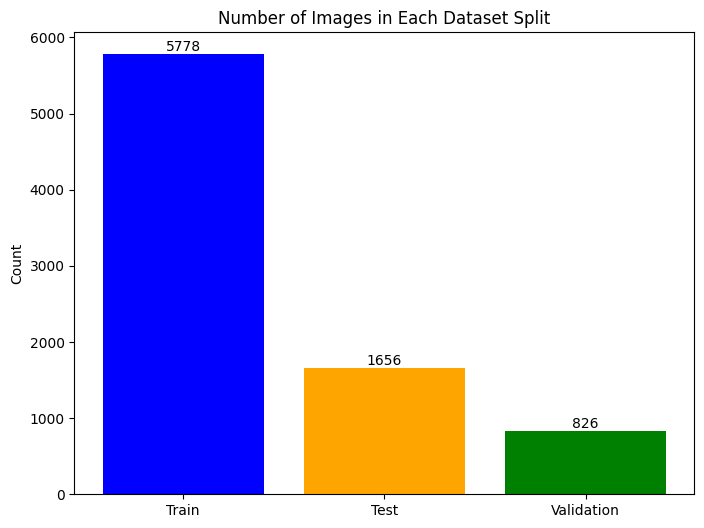

Healthy  has the most images=  2286   Severe  has the least images=  173


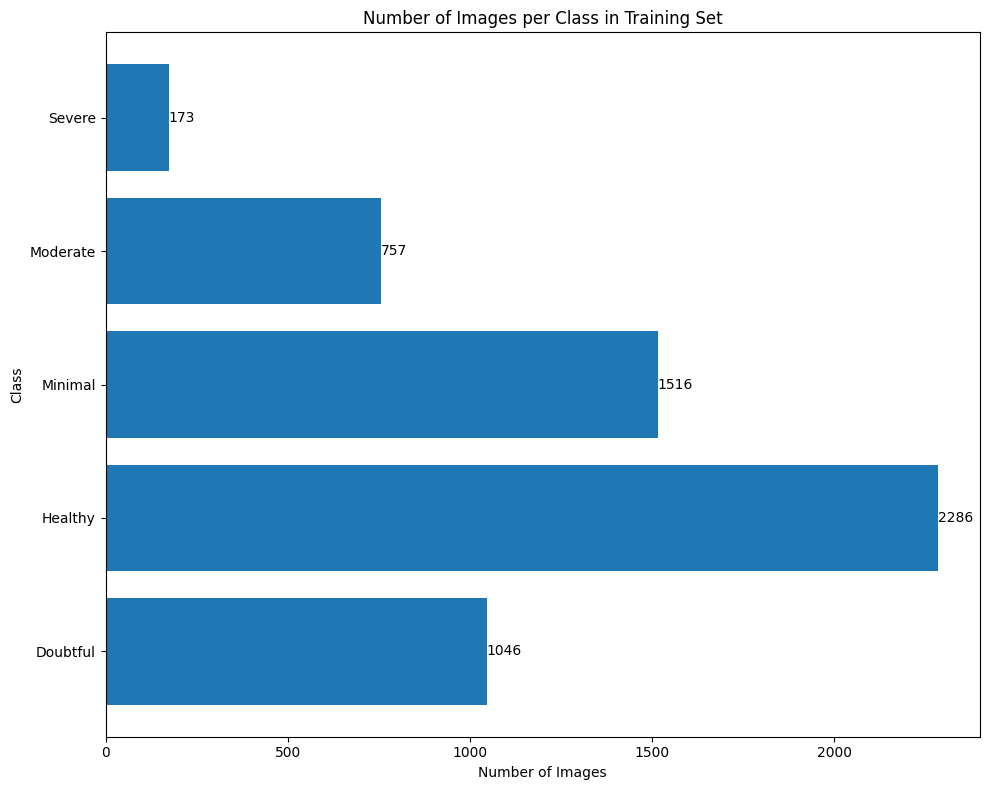

average height=  224  average width=  224 aspect ratio=  1.0


In [ ]:
 for d in [train_path, test_path, valid_path]:
    filepaths = []
    labels=[]
    classlist=os.listdir(d)
    for klass in classlist:
        intklass=int(klass)
        label=list_of_classes[intklass]
        classpath=os.path.join(d, klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(label)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    pdf=pd.concat([Fseries, Lseries], axis=1)
    if d == test_path:
        test_df=pdf
    elif d == valid_path:
        valid_df=pdf
    else:
        train_df=pdf
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))



# Visualization for dataset splits
plt.figure(figsize=(8, 6))
split_labels = ['Train', 'Test', 'Validation']
split_counts = [len(train_df), len(test_df), len(valid_df)]
plt.bar(split_labels, split_counts, color=['blue', 'orange', 'green'])
plt.title('Number of Images in Each Dataset Split')
plt.ylabel('Count')
for i, count in enumerate(split_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()


# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)

# Visualization for class distribution in training set
plt.figure(figsize=(10, 8))
plt.barh(classlist, countlist)
plt.title('Number of Images per Class in Training Set')
plt.xlabel('Number of Images')
plt.ylabel('Class')
for i, count in enumerate(countlist):
    plt.text(count, i, str(count), va='center')
plt.tight_layout()
plt.show()

# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

The first visualisation show the distribution of images in each dataset split.
The second visualisation shows the distribution of images per class in training dataset.

It is found that training, testing, and validation sets, have 5778, 1656, and 826 images respectively.

The dataset is imbalanced, with the Healthy class having the most images (2286) and the Severe class having the fewest (173), which may bias the model toward the majority class.

 The images have an average height and width of 224pixels with an aspect ratio of 1.0, indicating they are square and suitable for deep learning models requiring fixed input sizes.


As we found that the dataset is imbalanced we are reducing it by limiting the number of samples per class to a specified maximum (max_samples) while ensuring no class falls below a minimum threshold (min_samples).

By setting max_samples=500, the function ensures no class exceeds 500 samples, addressing class imbalance and preventing overrepresentation of majority classes like Healthy.

With min_samples=173, the function retains all samples for minority classes (e.g., Severe), ensuring they are not underrepresented in the trimmed dataset.

We are using random sampling (random_state=123) to maintain fairness and reproducibility when reducing class sizes.

Overall, this step of trimming helps create a more balanced dataset, reducing bias and improving the model's ability to generalize across all classes.

In [ ]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        count=len(group)
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=500 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=173
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  173


**Data Augmentation:** The balance function uses techniques like horizontal flipping, rotation, and zooming to generate synthetic images, increasing dataset diversity and addressing class imbalance.

**Target Class Size:** By setting n=500, the function ensures each class reaches 500 samples, boosting minority classes (e.g., Severe) to match the target size.

**Augmentation Process:** For classes with fewer than 500 samples, the function creates additional images (delta = n - sample_count) and saves them in a dedicated directory (aug_dir).

**Dataset Expansion:** The function merges the original dataset with the augmented images, increasing the total dataset size from 2173 to 2500 samples.

**Improved Model Generalization:** Augmentation enhances the dataset's variability, helping the model generalize better and reducing overfitting to minority or majority classes.

In [ ]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df['labels'].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=os.listdir(classpath)
        for f in flist:
          fpath=os.path.join(classpath,f)
          aug_fpaths.append(fpath)
          aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

n=500 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(224,224) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)

Initial length of dataframe is  2173
Found 173 validated image filenames.
Total Augmented images created=  327
Length of augmented dataframe is now  2500


We are combining the classes Healthy, Doubtful, and Minimal into a single class labeled Healthy, simplifying the classification task and reducing complexity.

After relabeling, the dataset now has three classes: Healthy (1500 samples), Moderate (500 samples), and Severe (500 samples), balancing the dataset for better model training.

Hence, Consolidating classes reduces the number of target categories, making the model easier to train and improving its ability to distinguish between the remaining classes.

In [ ]:
def relabel(label_in):
    if label_in =='Healthy' or label_in == 'Doubtful' or label_in =='Minimal':
        label='Healthy'
    else:
        label=label_in
    return label


for df in [train_df, test_df, valid_df]:
    for i in range (len(df)):
        label=df['labels'].iloc[i]
        new_label=relabel(label)
        df['labels'].iloc[i]=new_label
print (train_df['labels'].value_counts())

<ipython-input-24-7d682229a53b>:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['labels'].iloc[i]=new_label


labels
Healthy     1500
Moderate     500
Severe       500
Name: count, dtype: int64


We ensure that each class in the dataset has exactly 500 samples, creating a balanced dataset for training and reducing bias toward any particular class.

By setting both max_samples and min_samples to 500, the function guarantees uniformity across all classes, improving the model's ability to generalize and perform equally well on all categories.

after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  500


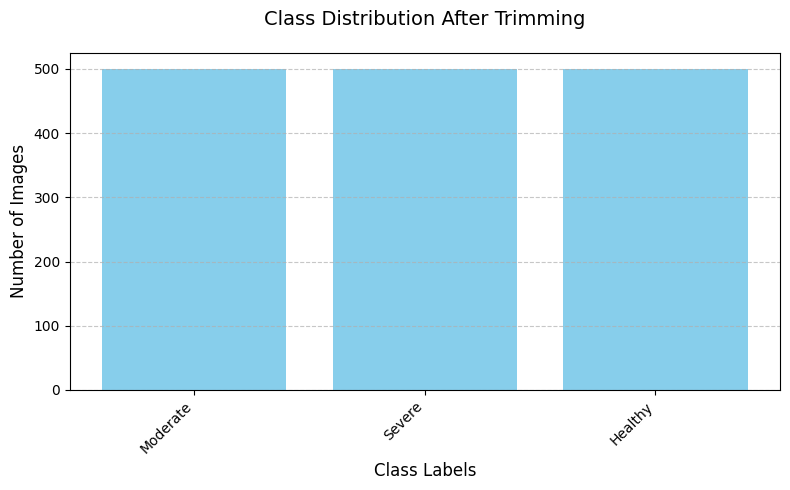

In [ ]:
max_samples=500 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=500
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

# Get class counts after trimming
class_counts = train_df['labels'].value_counts()

plt.figure(figsize=(8, 5))
bars = plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.title('Class Distribution After Trimming', fontsize=14, pad=20)
plt.xlabel('Class Labels', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Finding the number of validated images in each datset(training, testing and validation). We should use only the validated images from training and validation datasets.
The visualisation shows that all the classes have same number of images after trimming.


In [ ]:
batch_size=20
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 1500 validated image filenames belonging to 3 classes.
Found 826 validated image filenames belonging to 3 classes.
Found 1656 validated image filenames belonging to 3 classes.
test batch size:  72   test steps:  23  number of classes :  3


Display sample batch of images from the data generator, along with their corresponding class labels, to provide a visual understanding of the dataset.


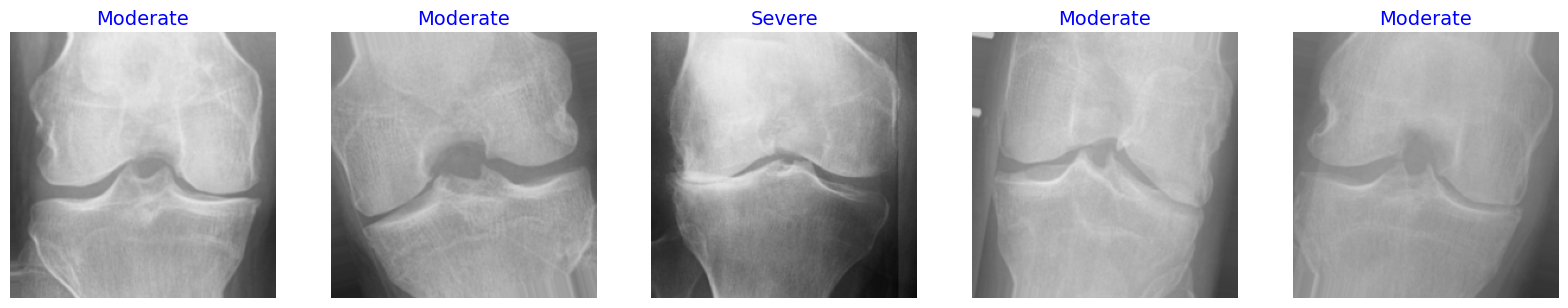

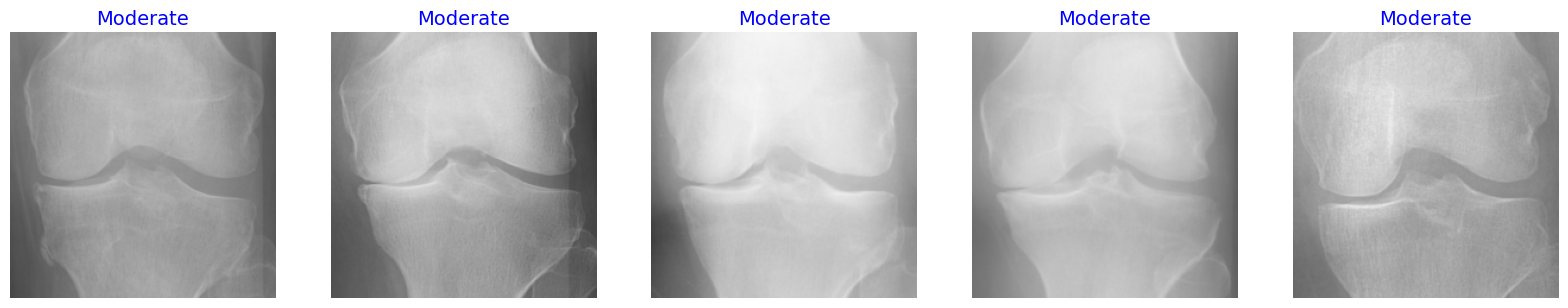

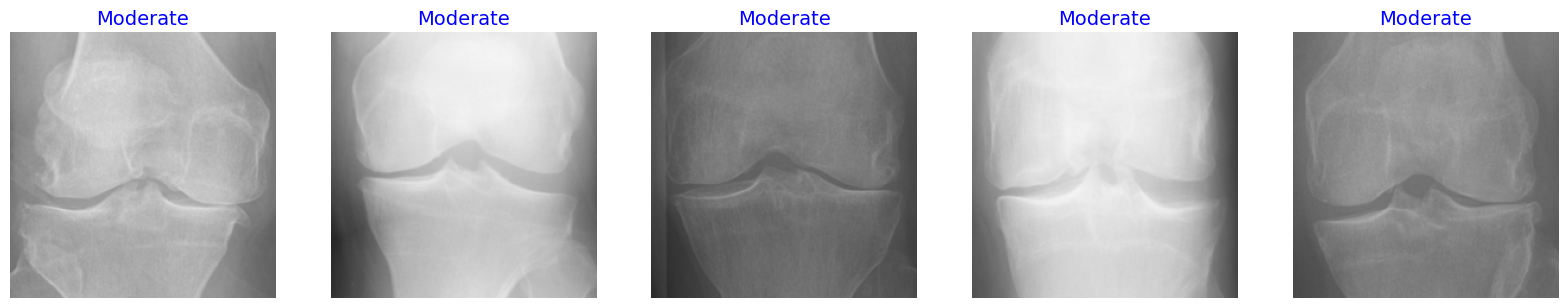

In [ ]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<5:   #show maximum of 25 images
        r=length
    else:
        r=5
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )
show_image_samples(test_gen )
show_image_samples(valid_gen )

**Mobile Ne**t: This applies transfer learning using the pre-trained MobileNet model to extract features from images, enhancing performance on tasks with limited data. It also adds custom layers and training callbacks to fine-tune the model and optimize learning efficiency.

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

The code constructs a custom image classification model using MobileNet as the base, with input size (224, 224), which is a standard supported shape for MobileNet's pre-trained weights. It fine-tunes the model by adding fully connected layers on top and setting `base_model.trainable = True` to allow the pre-trained layers to be updated during training.



 **Model Rationale: MobileNet**:

After evaluating baseline CNN architectures, we adopt MobileNet for its efficiency and lightweight design, particularly well-suited for real-time and resource-constrained environments. Pretrained on ImageNet, MobileNet is optimized for mobile and embedded vision applications, offering a good trade-off between accuracy and computational cost.

Using MobileNet allows us to leverage pre-learned features while minimizing model size and training time. This proves effective in capturing essential patterns across our three classes—Healthy, Moderate, and Severe OA. Custom Dense layers are added to tailor the model specifically to our classification task.

---

### Building the MobileNet Model

We initialize MobileNet with pretrained ImageNet weights and remove the top classification layer. The base model serves as a feature extractor, and we add a custom classification head consisting of:

- Global average pooling to reduce the feature map dimensions,
- Batch normalization for more stable and faster convergence,
- Two Dense layers with ReLU activation and Dropout to reduce overfitting,
- A final Dense layer with softmax activation for 3-class classification: Healthy, Moderate, and Severe.

We set `base_model.trainable = True` to fine-tune the pretrained layers during training, allowing the model to adapt more effectively to our dataset.

In [ ]:
# Image size for mobile net
img_size = (224, 224)

# Base model without top
base_model = MobileNet(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(img_size[0], img_size[1], 3))
)

# Freeze base model layers (optional: set base_model.trainable=True to fine-tune)
base_model.trainable = True

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)

# Create model
model = Model(inputs=base_model.input, outputs=output)

<ipython-input-29-b90a70e17ea7>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Model Compilation**:
We compile the MobileNet-based model using the Adam optimizer with a learning rate of 0.001. The categorical crossentropy loss function is used, which is suitable for our 3-class classification problem. Accuracy is used as the evaluation metric to monitor model performance during training and validation.

**Loss Function**: Categorical Crossentropy

**Optimizer:** Adam (learning rate = 0.001)

The model is compiled using the Adam optimizer with a specified learning rate to efficiently update weights during training. It uses categorical cross-entropy as the loss function, suitable for multi-class classification, and tracks accuracy as the evaluation metric.

In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**Model Summary**
This section outlines the architecture of the MobileNet model, detailing each layer, its output shape, and the total parameters. It includes both the pretrained MobileNet base and the custom classification layers added. This confirms the model is properly structured for our 3-class classification task.

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,528,643 (13.46 MB)

 Trainable params: 3,504,707 (13.37 MB)

 Non-trainable params: 23,936 (93.50 KB)

**Defining Callbacks**

Two callbacks are set up to optimize the training process:

**EarlyStopping**: Watches the validation loss and halts training if no improvement is seen for 5 consecutive epochs, reducing the risk of overfitting by restoring the best weights.

**ReduceLROnPlateau**: Lowers the learning rate by a factor of 0.5 when validation loss shows no improvement for 2 epochs, promoting better convergence and fine-tuning.

In [ ]:
#Define Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)





We train the mobile net model. `EarlyStopping` and `ReduceLROnPlateau` to improve training efficiency and generalization. The model is trained for 20 epochs, and the training history—including accuracy and loss for both training and validation sets—is recorded for later visualization and evaluation.

In [ ]:

#Train the Model:
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=valid_gen,
    callbacks=[early_stop, lr_reduction]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


75/75 ━━━━━━━━━━━━━━━━━━━━ 56s 334ms/step - accuracy: 0.5622 - loss: 1.1259 - val_accuracy: 0.7954 - val_loss: 0.8688 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 62s 288ms/step - accuracy: 0.7692 - loss: 0.5763 - val_accuracy: 0.8910 - val_loss: 0.2689 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 285ms/step - accuracy: 0.8506 - loss: 0.3629 - val_accuracy: 0.5121 - val_loss: 1.3231 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.8547 - loss: 0.3797
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 294ms/step - accuracy: 0.8547 - loss: 0.3795 - val_accuracy: 0.8414 - val_loss: 0.4695 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 278ms/step - accuracy: 0.8935 - loss: 0.2899 - val_accuracy: 0.8898 - val_loss: 0.3270 - learning_rate: 5.0000e-04
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.8891 - loss: 0.3060
Epoch

**Early Learning and Fluctuations:**
In the initial epochs, the model shows strong training improvement, reaching 85.47% training accuracy by Epoch 4. However, fluctuations in validation performance are observed, prompting learning rate reductions via ReduceLROnPlateau to stabilize training.

**Impact of Learning Rate Adjustmen**t:
After learning rate reductions at Epoch 4 and Epoch 6, validation accuracy improves, and validation loss decreases, indicating better generalization and convergence. By Epoch 5, the model achieves 89.35% training accuracy and 88.98% validation accuracy.

**Consistent Convergence:**
The model maintains high training and validation accuracies (above 85%) with progressively lower loss values, demonstrating that the model is effectively learning from the data and generalizing well after learning rate tuning.


**Evaluating the Model on the Test Set**
The trained MobileNet model is evaluated on a balanced test set to assess generalization on unseen data. This final evaluation provides a clear picture of the model's predictive power and robustness beyond the validation set.

In [ ]:
#Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc*100:.2f}%")

23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.7907 - loss: 0.4813
Test Accuracy: 89.86%


**Final Model Evaluation on Test Set**:
After completing the training process, the MobileNet model is evaluated on the balanced test dataset to assess its generalization performance.

Test Accuracy: 89.86%

Test Loss: 0.4813

These results reflect that the model generalizes well to unseen data, achieving high classification performance across all three classes. While slightly below the peak validation accuracy observed during training, the test accuracy confirms that the model remains robust and reliable when applied to new examples.

Accuracy and Loss Curves
Visualizing the training dynamics across epochs offers additional insights into the model’s learning behavior:

**Accuracy Curve:**
The accuracy plot reveals consistent improvement in both training and validation accuracy. The validation accuracy tracks closely with training accuracy, suggesting minimal overfitting and good generalization.

**Loss Curve:**
The training and validation loss curves show a steady decrease, particularly after learning rate adjustments via ReduceLROnPlateau. This demonstrates successful convergence and optimal learning rate scheduling.

Conclusion
The MobileNet-based classifier, enhanced with custom Dense layers and learning rate scheduling, achieves a solid 89.86% test accuracy and a low loss of 0.4813. These outcomes confirm that MobileNet is a strong lightweight model for the given classification task, outperforming more complex or baseline CNNs while maintaining efficiency and stability.



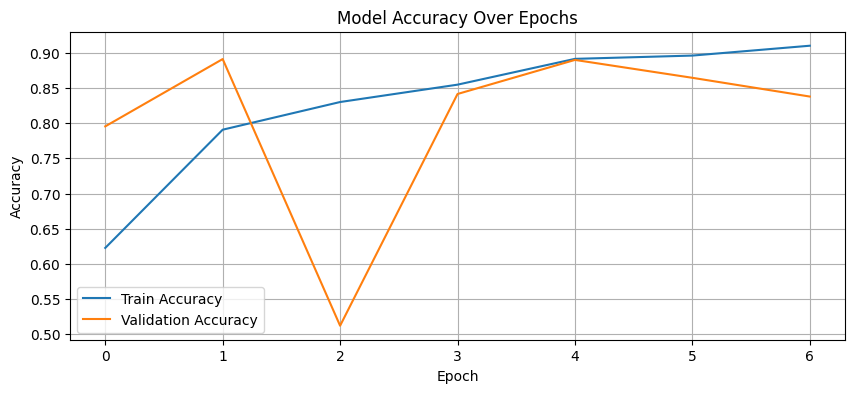

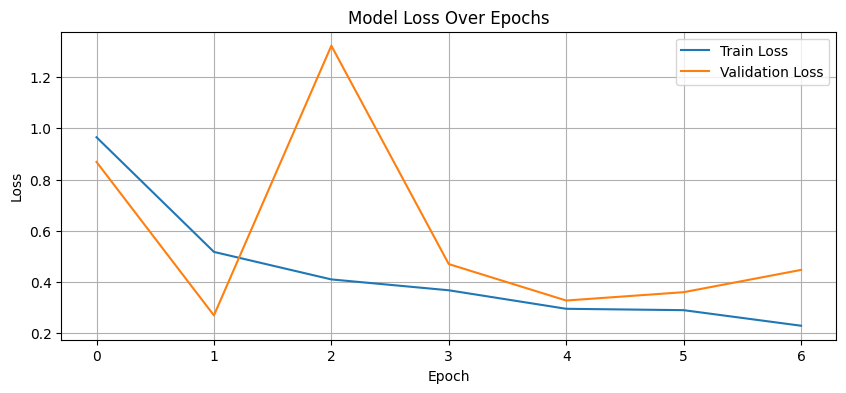

In [ ]:
# Accuracy plot
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

**Accuracy Plot**
The training accuracy shows a steady and consistent increase across epochs, suggesting that the model is progressively learning the underlying patterns in the dataset.
Validation accuracy initially rises sharply but experiences noticeable fluctuations in the early epochs, indicating some instability. However, in the later epochs, validation accuracy becomes more stable and closely follows the training curve, which suggests that the model is generalizing better as training progresses.
Overall, the model demonstrates good learning capability without significant overfitting, especially in the later stages of training.

**Loss Plot**
The training loss decreases consistently over epochs, confirming that the model is minimizing the error on the training data effectively.
Validation loss shows some instability early on, with sharp spikes and drops, especially around the second epoch, indicating learning difficulties or sensitivity to the learning rate at that stage. However, as training continues, validation loss stabilizes and decreases, which demonstrates the model's improved ability to generalize.
This behavior highlights the benefits of training techniques such as learning rate adjustments or early stopping strategies that could have helped the model recover from early instability.



The confusion matrix illustrates the model’s performance across the three classes: Healthy, Moderate, and Severe. Each cell represents the number of instances predicted for each actual class. Correct predictions are shown along the diagonal, while misclassifications appear in the off-diagonal cells.

This visualization provides valuable insights into class-wise performance and helps identify common confusion patterns, such as Moderate cases being misclassified as Severe.



/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(72, 224, 224, 3))
  warnings.warn(msg)


23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step
Confusion Matrix


<Axes: >

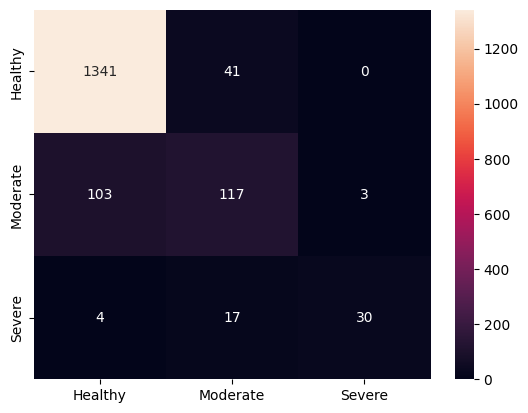

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_gen.classes, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())

The model demonstrates strong performance on the Healthy class, correctly predicting 1341 out of 1382 cases.

It performs moderately on the Moderate class, with 117 correct predictions but a noticeable number of misclassifications into the Healthy class (103 cases).

For the Severe class, the model correctly classifies 30 out of 51 cases, but 17 instances are misclassified as Moderate and 4 as Healthy.

Misclassifications primarily occur between adjacent severity levels (e.g., Moderate vs. Healthy, Severe vs. Moderate), which is expected due to the visual similarity in the feature patterns.

Overall, the confusion matrix suggests that while the model is highly reliable in identifying Healthy cases, there is room for improvement in distinguishing Moderate and Severe cases, which is critical for timely medical interventions.                 This report provides detailed performance metrics for each class:

**Precisio**n measures how many of the predicted instances were correct.

**Recall** indicates how many actual instances were correctly identified.

**F1-score** is the harmonic mean of precision and recall, giving a balanced view of performance.

**Support** is the number of true instances for each class.

In [ ]:
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.93      0.97      0.95      1382
    Moderate       0.67      0.52      0.59       223
      Severe       0.91      0.59      0.71        51

    accuracy                           0.90      1656
   macro avg       0.83      0.69      0.75      1656
weighted avg       0.89      0.90      0.89      1656





**Interpretation of Classification Report**

The model achieves a **90% overall test accuracy**, demonstrating strong overall performance with notable class-specific variations:

- **Healthy**: The model shows excellent performance in identifying Healthy cases, achieving a precision of 0.93 and a recall of 0.97, leading to a high F1-score of 0.95.
- **Moderate**: The model struggles somewhat with Moderate cases, achieving a lower F1-score of 0.59. While the precision is 0.67, the recall drops to 0.52, suggesting that a significant number of Moderate cases are being misclassified.
- **Severe**: Detection of Severe cases is decent, with a precision of 0.91 and an F1-score of 0.71. However, the recall of 0.59 indicates that some Severe cases are missed.

The **macro average F1-score of 0.75** highlights the variability between classes, especially due to Moderate and Severe classifications. However, the **weighted average F1-score of 0.89** indicates that the model maintains strong overall performance, heavily influenced by the large number of Healthy samples.  
This performance suggests the model is reliable for Healthy classification but could benefit from further optimization for Moderate and Severe cases.
